In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import mlflow
import mlflow.pytorch
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
from utils.lstm_ativacao import LSTMAtivacao
from utils.carregar_modelo import carregar_modelo_completo
import os

### Challenge:

- predizer o valor de fechamento da bolsa de valores de uma empresa 
- pipeline de desenvolvimento:
    - criação do modelo preditivo
    - deploy do modelo em uma API que permita a previsão de preços de ações

In [22]:
# Set device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Dados históricos:

- techfase4\process\get_data.ipynb
- tensores não aceitam string nem datas

In [6]:
df0 = pd.read_pickle("../data/dados.pkl")
df0["Date"] = pd.to_datetime(df0["Date"])
df0["Timestamp"] = df0["Date"].astype("int64") // 10**9  # segundos desde 1970

In [7]:
df = df0.sort_values("Date")
df = df.drop(columns=["Date", 'Volume', 'Ticker'])

In [5]:
df.head()

,Close,High,Low,Open,Timestamp
0,137.391541,137.623750,136.444877,137.087896,1514851200
1,138.025620,138.418577,136.632416,136.632416,1514937600
2,139.659958,140.088633,138.222097,138.427502,1515024000
3,140.812042,140.856699,139.436704,139.865379,1515110400
4,141.937302,142.008750,140.070766,140.544098,1515369600


### Inspecionando os dados para definição da janela temporal

In [8]:
df.describe()

,Close,High,Low,Open,Timestamp
count,1886.000000,1886.000000,1886.000000,1886.000000,1.886000e+03
mean,249.981714,252.312014,247.558342,249.852386,1.633012e+09
std,74.017020,74.724710,73.355300,74.013796,6.832791e+07
min,121.532249,124.487137,120.586697,122.559651,1.514851e+09
25%,175.060432,176.399953,173.499708,175.099667,1.573711e+09
50%,266.379333,268.394702,263.556193,265.185161,1.632917e+09
75%,308.091064,311.442902,305.851461,308.207715,1.692122e+09
max,396.284912,396.384425,391.758116,394.201458,1.751501e+09


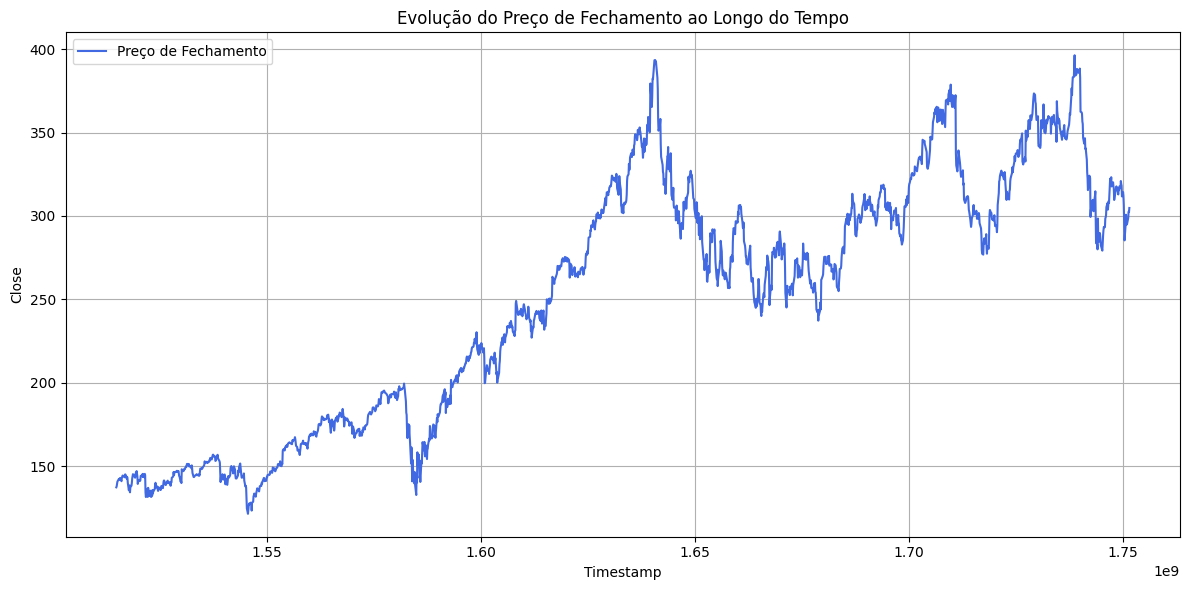

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(df["Timestamp"], df["Close"], label="Preço de Fechamento", color="royalblue")
plt.xlabel("Timestamp")
plt.ylabel("Close")
plt.title("Evolução do Preço de Fechamento ao Longo do Tempo")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Criando sequências para LSTM:
- Modelos LSTM (Long Short-Term Memory) não aprendem apenas com os dados atuais, mas com janelas do passado.
- Eles precisam ver os últimos n passos no tempo para prever o próximo valor.
- A função create_sequences cria exatamente essas janelas.
- O tamanho da sequência: quantos passos de tempo o modelo vai olhar de uma vez. Ex: 20 dias passados do dado por input.

In [39]:
sequence_length = 20  # Length of the input sequences
forecast_horizon = 20 # Number of steps to forecast ahead

In [40]:
def create_sequences(data, sequence_length, forecast_horizon, target_index):
    X, y = [], []
    for i in range(len(data) - sequence_length - forecast_horizon + 1):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length:i+sequence_length+forecast_horizon, target_index])
    return np.array(X), np.array(y)

target_index = df.columns.get_loc("Close")
data_array = df.to_numpy()
X_seq, y_seq = create_sequences(data_array, sequence_length, forecast_horizon, target_index)

### Convertendo para tensores e DataLoader

In [41]:
X_tensor = torch.tensor(X_seq, dtype=torch.float32)
y_tensor = torch.tensor(y_seq, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [42]:
num_features = X_tensor.shape[2]
print("Number of features:", num_features)

Number of features: 5


In [43]:
df.shape

(1886, 5)

### LSTM

In [44]:
# Hyperparameters
input_size = X_tensor.shape[2]      # Number of features in the input data
hidden_size = 100     # Number of hidden units in the LSTM
num_layers = 2       # Number of LSTM layers
output_size = forecast_horizon     # prever 60 dias à frente
num_epochs = 100
batch_size = 64
learning_rate = 0.001
num_samples = 10000  # Number of artificial samples to generate

### Testando 3 opções de ativações para escolher a melhor

In [45]:
ativacoes = {
    "ReLU": nn.ReLU(),
    "Tanh": nn.Tanh(),
    "Sem_Ativacao": nn.Identity()
}

### Classe criada em arquivo separado (lstm_ativacao.py) para ser também usada no app.py

In [46]:
def avaliar_modelo(model, loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            output = model(X_batch).squeeze()
            y_true.extend(y_batch.numpy())
            y_pred.extend(output.numpy())

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)

    return y_true, y_pred, mae, mse

### Rodando o modelo com diferentes ativações

Treinando com ativação: ReLU
y_pred shape: (370, 20)
y_pred preview: [244.76051 244.99664 245.16751 245.29106 245.37154 245.54816 245.76013
 245.8437  245.94383 245.99619 246.131   246.39883 246.4832  246.49922
 246.62561 246.68942 246.70016 246.9614  247.06013 247.25739]
Valores únicos: [244.76051 244.99663 244.99664 245.16751 245.16759 245.29103 245.29106
 245.37154 245.37155 245.54813 245.54816 245.76013 245.8437  245.94383
 245.94385 245.99619 245.9962  246.13098 246.131   246.39883 246.48317
 246.4832  246.49918 246.49922 246.62561 246.62563 246.6894  246.68942
 246.70016 246.9614  247.06012 247.06013 247.25739 247.2574 ]


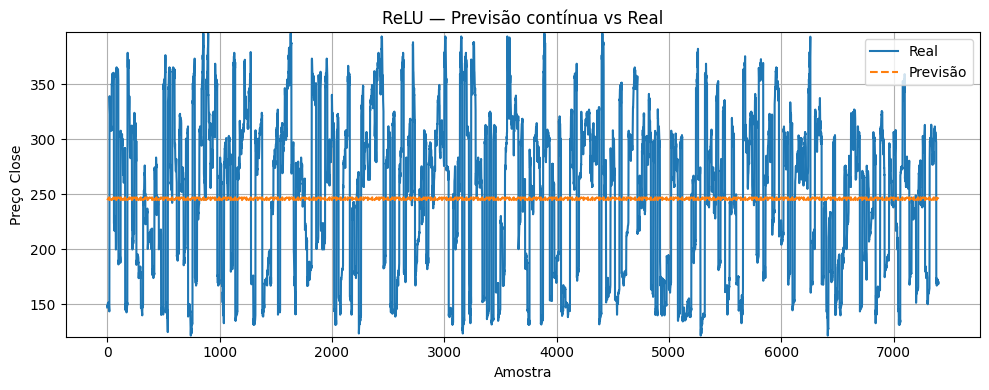

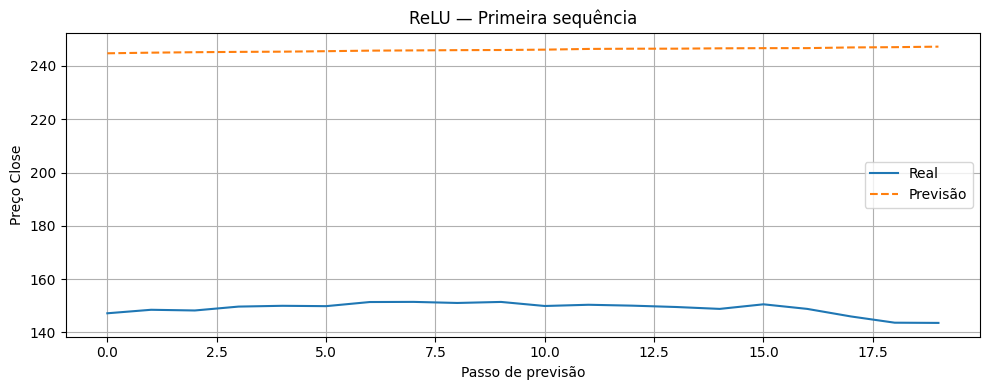

Treinando com ativação: Tanh
y_pred shape: (370, 20)
y_pred preview: [248.48482 248.55022 248.58798 248.62157 248.64198 248.78705 248.93288
 248.95741 249.07907 249.16406 249.3288  249.37384 249.41904 249.48378
 249.64786 249.67012 249.76666 249.9255  249.88266 250.06416]
Valores únicos: [248.48482 248.48486 248.55019 248.55022 248.58798 248.58807 248.62146
 248.62157 248.64198 248.642   248.78702 248.78705 248.93288 248.95738
 248.95741 249.07906 249.07907 249.16406 249.3288  249.32886 249.37384
 249.41904 249.41908 249.48378 249.4838  249.64786 249.67004 249.67012
 249.76666 249.88266 249.9255  250.06416 250.06418]


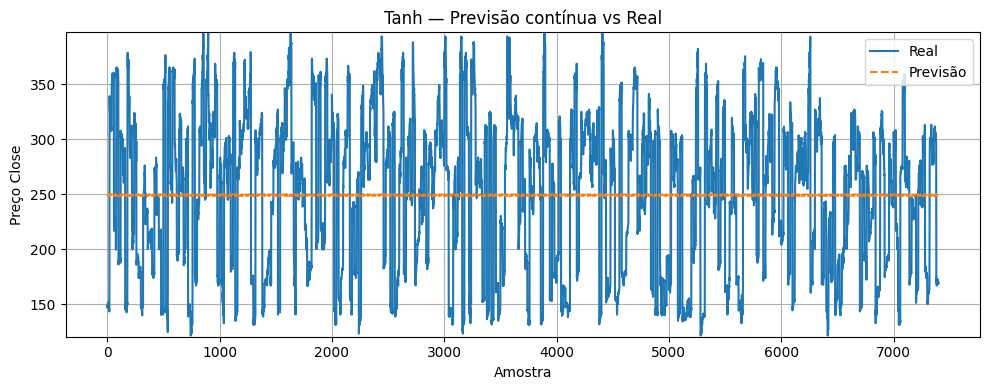

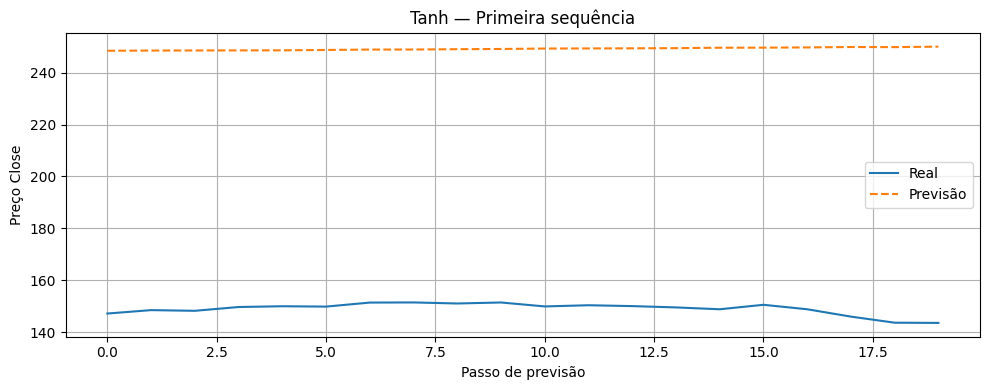

Treinando com ativação: Sem_Ativacao
y_pred shape: (370, 20)
y_pred preview: [246.24495 246.38963 246.5586  246.97418 246.81633 247.11656 247.1713
 247.21059 247.40533 247.4133  247.46078 247.40561 247.61066 247.62521
 248.03333 248.06718 248.21234 248.25435 248.26288 248.14206]
Valores únicos: [246.24495 246.38957 246.38963 246.5586  246.81633 246.97417 246.97418
 247.11655 247.11656 247.1713  247.17131 247.21059 247.4053  247.40533
 247.40561 247.40562 247.4133  247.41331 247.46078 247.46082 247.61061
 247.61066 247.6252  247.62521 248.03333 248.03336 248.06714 248.06718
 248.14206 248.14207 248.21234 248.25435 248.25436 248.26288]


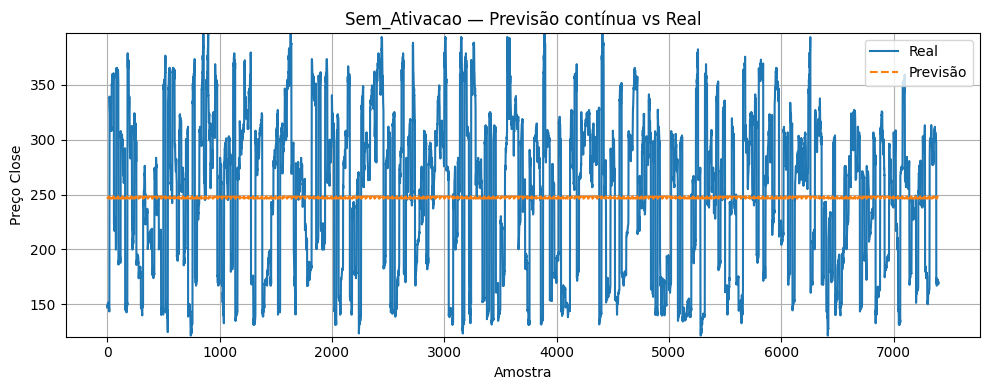

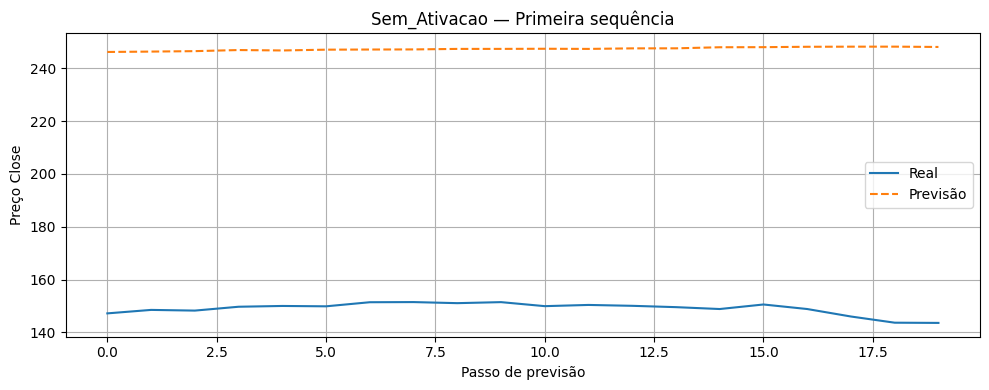

In [47]:
resultados = {}
modelos_salvos = {}

for nome, funcao in ativacoes.items():
    print(f"Treinando com ativação: {nome}")
    
    model = LSTMAtivacao(input_size, hidden_size, num_layers, output_size, funcao).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    # Início do experimento no MLflow
    mlflow.set_experiment("LSTM Artificial Data Regression")
    with mlflow.start_run(run_name=f"Ativação: {nome}"):
        # Log dos parâmetros
        mlflow.log_param("activation", nome)
        mlflow.log_param("input_size", input_size)
        mlflow.log_param("hidden_size", hidden_size)
        mlflow.log_param("num_layers", num_layers)
        mlflow.log_param("output_size", output_size)
        mlflow.log_param("num_epochs", num_epochs)
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("learning_rate", learning_rate)
        
        # Treinamento
        for epoch in range(num_epochs):
            model.train()
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                pred = model(X_batch)
                loss = loss_fn(pred, y_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Avaliação sem scaler
        y_true, y_pred, mae, mse = avaliar_modelo(model, test_loader)
        resultados[nome] = {"MAE": mae, "MSE": mse}
        modelos_salvos[nome] = model.state_dict()

        # Diagnóstico rápido das previsões
        print("y_pred shape:", np.array(y_pred).shape)
        print("y_pred preview:", np.array(y_pred)[0])
        print("Valores únicos:", np.unique(np.array(y_pred)))

        # Log das métricas
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("MSE", mse)

       # Log do gráfico
        plt.figure(figsize=(10, 4))

        # Junta todas as previsões e reais em uma única sequência
        plt.plot(np.ravel(y_true), label="Real")
        plt.plot(np.ravel(y_pred), linestyle="--", label="Previsão")
        plt.title(f"{nome} — Previsão contínua vs Real")
        plt.xlabel("Amostra")
        plt.ylabel("Preço Close")
        plt.grid(True)

        # Zoom automático com leve folga
        plt.ylim(min(np.ravel(y_true)) - 1, max(np.ravel(y_true)) + 1)

        # Elimina duplicatas na legenda
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())

        plt.tight_layout()
        plt.show()

        # Visualização de uma única amostra
        plt.figure(figsize=(10, 4))
        plt.plot(y_true[0], label="Real")
        plt.plot(y_pred[0], linestyle="--", label="Previsão")
        plt.title(f"{nome} — Primeira sequência")
        plt.xlabel("Passo de previsão")
        plt.ylabel("Preço Close")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

### Avaliando o resultado

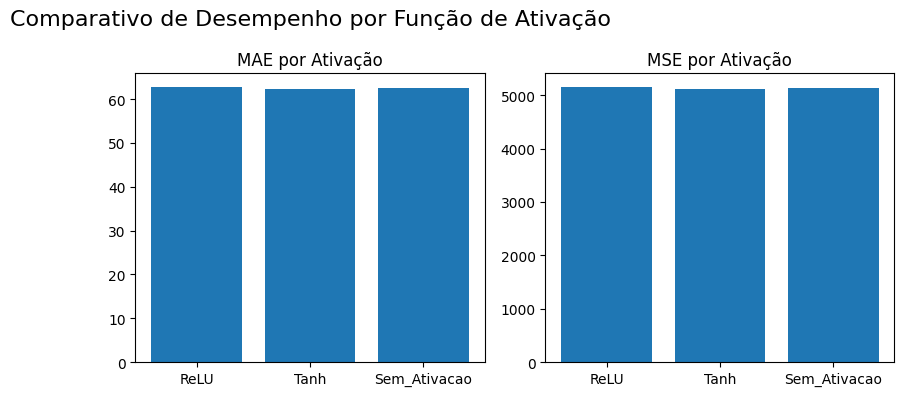

In [48]:
labels = list(resultados.keys())
mae_vals = [resultados[k]["MAE"] for k in labels]
mse_vals  = [resultados[k]["MSE"] for k in labels]

x = np.arange(len(labels))

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 2)
plt.bar(x, mae_vals, tick_label=labels)
plt.title("MAE por Ativação")

plt.subplot(1, 3, 3)
plt.bar(x, mse_vals, tick_label=labels)
plt.title("MSE por Ativação")

plt.suptitle("Comparativo de Desempenho por Função de Ativação", fontsize=16)
plt.tight_layout()
plt.show()

In [49]:
print("Modelos salvos disponíveis:", modelos_salvos.keys())

Modelos salvos disponíveis: dict_keys(['ReLU', 'Tanh', 'Sem_Ativacao'])


### Selecionado o melhor modelo

In [51]:
# Seleção do melhor modelo com base no menor MAE
melhor_ativacao = min(resultados, key=lambda k: resultados[k]["MAE"])
melhor_mae = resultados[melhor_ativacao]["MAE"]
melhor_mse = resultados[melhor_ativacao]["MSE"]

print(f"\n⭐ Melhor ativação: {melhor_ativacao}")
print(f"🔹 MAE: {melhor_mae:.4f} | MSE: {melhor_mse:.4f}")

# Carrega o modelo correspondente
melhor_modelo = LSTMAtivacao(input_size, hidden_size, num_layers, output_size, ativacoes[melhor_ativacao]).to(device)
melhor_modelo.load_state_dict(modelos_salvos[melhor_ativacao])
melhor_modelo.eval()



⭐ Melhor ativação: Tanh
🔹 MAE: 62.2720 | MSE: 5120.9105


LSTMAtivacao(
  (lstm): LSTM(5, 100, num_layers=2, batch_first=True, dropout=0.2)
  (regressor): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=20, bias=True)
  )
)

### Fazendo novas previsões

In [52]:
steps_ahead = 15

In [53]:
def multi_step_forecast(model, last_sequence, steps_ahead=steps_ahead):
    """
    Gera previsão direta de até 60 dias com base na última sequência.
    """
    model.eval()
    steps_ahead = min(max(1, steps_ahead), 60)  # garante entre 1 e 60

    with torch.no_grad():
        out = model(last_sequence.unsqueeze(0))  # shape: (1, 60)
        preds = out.squeeze().cpu().numpy().tolist()

    return preds[:steps_ahead]

In [54]:
last_seq = X_tensor[-1]  # última sequência do dataset
multi_preds = multi_step_forecast(melhor_modelo, last_seq, steps_ahead)

In [55]:
close_index = df.columns.get_loc("Close")

In [57]:
# Última data conhecida dataset original
last_date = df0["Date"].max()  # ou df.index.max() se estiver no índice
last_date

Timestamp('2025-07-03 00:00:00')

In [58]:
# Número de passos previstos
steps_ahead = len(multi_preds)

# Gera as datas futuras
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=steps_ahead, freq='D')
future_dates = future_dates.strftime('%Y/%m/%d')


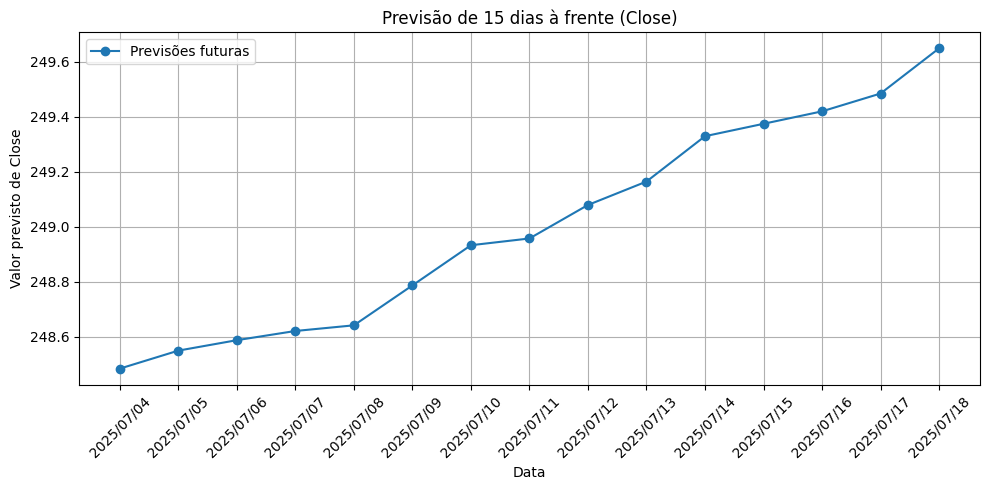

In [59]:
plt.figure(figsize=(10, 5))
plt.plot(future_dates, multi_preds, marker='o', label="Previsões futuras")
plt.title(f"Previsão de {steps_ahead} dias à frente (Close)")
plt.xlabel("Data")
plt.ylabel("Valor previsto de Close")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Salvando o modelo

In [67]:
#torch.save(melhor_modelo.state_dict(), "modelo_lstm_v2.pth")

In [ ]:
def salvar_modelo(model, input_size, hidden_size, num_layers, output_size,
                  ativacao_nome, caminho_modelo="modelo_lstm.pt"):
    # Salva o modelo e metadados
    torch.save({
        "model_state": model.state_dict(),
        "input_size": input_size,
        "hidden_size": hidden_size,
        "num_layers": num_layers,
        "output_size": output_size,
        "activation": ativacao_nome
    }, caminho_modelo)

    print(f"Modelo salvo com sucesso: {caminho_modelo}")

In [ ]:
salvar_modelo_completo(
    model=melhor_modelo,
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=output_size,
    ativacao_nome=melhor_ativacao,
)

Modelo e scalers salvos com sucesso: modelo_lstm.pt, scaler.pkl, scaler_y.pkl


In [60]:
print("Modelo espera input_size =", melhor_modelo.lstm.input_size)

Modelo espera input_size = 5


In [ ]:
### Carregando o modelo salvo
# # Caminhos absolutos
# BASE_DIR = os.getcwd()
# model_path = os.path.join(BASE_DIR, "modelo_lstm.pt")
# scaler_path = os.path.join(BASE_DIR, "scaler.pkl")
# scaler_y_path = os.path.join(BASE_DIR, "scaler_y.pkl")

# # Carrega modelo e scalers
# model, scaler, scaler_y = carregar_modelo_completo(model_path, scaler_path, scaler_y_path)
# print(model_path)